# RAG Retrieval Model and Framework Testing

This notebook covers multiple experiments performed as follows: 
- chunk sizes
- chunk overlap
- embedding models
- ranking logic

##### Any AI based assistance, code completion was not used to solve this problem.

In [39]:
import warnings
warnings.filterwarnings('ignore')
import time
import tqdm
import random
import numpy as np
from utils import read_json
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer, util

In [2]:
dataset = read_json('./data/clean_questions_to_answers_dataset_v1.json')

In [3]:
context_passages = []
original_questions = []

for question, answers in dataset.items():
    combined_passage = " ".join(answers)    
    context_passages.append(combined_passage)
    original_questions.append(question)


In [4]:
len(context_passages), len(original_questions)

(14338, 14338)

# Passage Token Statistics

In [5]:
check_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

lengths = [len(check_tokenizer.encode(passage, truncation=False)) for passage in context_passages]

Token indices sequence length is longer than the specified maximum sequence length for this model (589 > 512). Running this sequence through the model will result in indexing errors


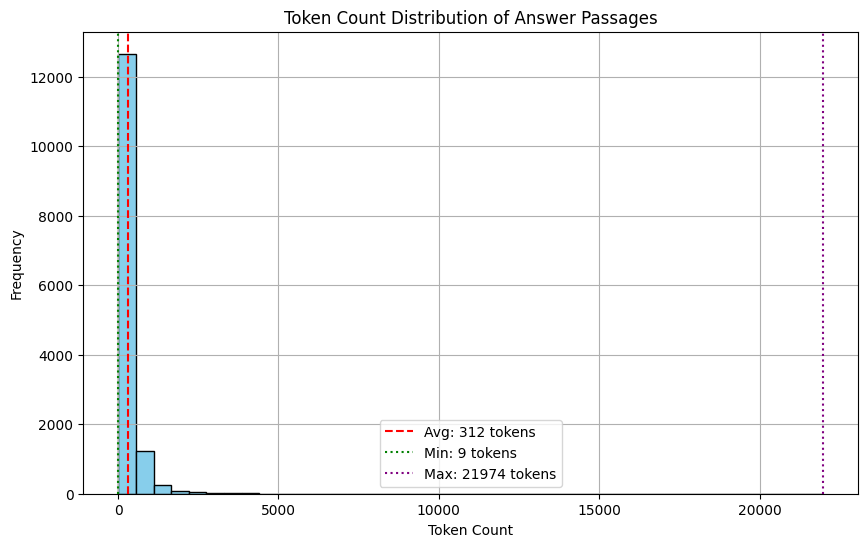

Min tokens: 9
Max tokens: 21974
Average tokens: 311.52


In [6]:
min_len = np.min(lengths)
max_len = np.max(lengths)
avg_len = np.mean(lengths)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=40, color='skyblue', edgecolor='black')
plt.axvline(avg_len, color='red', linestyle='dashed', linewidth=1.5, label=f'Avg: {avg_len:.0f} tokens')
plt.axvline(min_len, color='green', linestyle='dotted', linewidth=1.5, label=f'Min: {min_len} tokens')
plt.axvline(max_len, color='purple', linestyle='dotted', linewidth=1.5, label=f'Max: {max_len} tokens')
plt.title("Token Count Distribution of Answer Passages")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

print(f"Min tokens: {min_len}")
print(f"Max tokens: {max_len}")
print(f"Average tokens: {avg_len:.2f}")

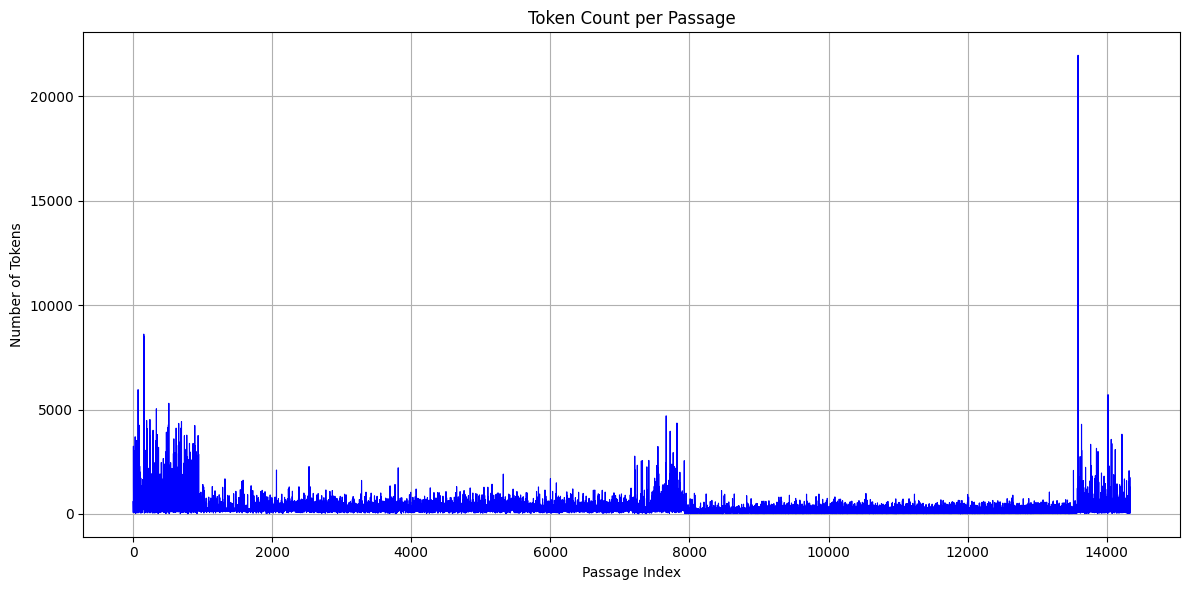

In [7]:
lengths = [len(check_tokenizer.encode(p, truncation=False)) for p in context_passages]


plt.figure(figsize=(12, 6))
plt.plot(range(len(lengths)), lengths, color='blue', linewidth=0.8)
plt.title("Token Count per Passage")
plt.xlabel("Passage Index")
plt.ylabel("Number of Tokens")
plt.grid(True)
plt.tight_layout()
plt.show()

# Filter Passages (Removing repetitive lines)

In [8]:
def remove_exact_duplicate_lines(text):
    """
    This function removes redundant lines within the same passage to avoid deduplication.
    Args:
        text (str) : passage of text
    Returns:
        str : de-duplicated text.
    """
    
    lines = [line.strip() for line in text.split('.') if line.strip()]
    unique_lines = []
    seen_lines = set()
    for line in lines:
        stripped_line = line.strip() # Consider stripping whitespace
        if stripped_line not in seen_lines:
            unique_lines.append(line)
            seen_lines.add(stripped_line)

    return ". ".join(unique_lines)

In [9]:
filtered_context_passages = [remove_exact_duplicate_lines(passage) for passage in context_passages]

# Index and Retrieval

In [26]:
import faiss
from sentence_transformers import CrossEncoder
from langchain.text_splitter import RecursiveCharacterTextSplitter

### Step 1: Create Chunks

In [11]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=100,
    length_function=len,
    
)

all_chunks = []

for i, doc in enumerate(filtered_context_passages):
    chunks = text_splitter.split_text(doc)
    question = original_questions[i]
    for chunk in chunks:
        all_chunks.append({
            "text": chunk,
            "question": question,  
            "answer_index": i + 1
        })

In [12]:
# creating separate chunks for questions to later index in a questions only vector index.
q_chunks = []

for i,quest in enumerate(original_questions):
    q_chunks.append({
        "text": quest,
        "answer_index": i + 1
    })    

### Step 2: Embed Chunks

In [13]:
# Following model is fine-tuned on medical domain data.
model = SentenceTransformer("abhinand/MedEmbed-small-v0.1")

chunk_texts = [chunk_info['text'] for chunk_info in all_chunks]

embeddings = model.encode(chunk_texts)

embedding_dimension = embeddings.shape[1]
num_chunks = len(all_chunks)

print(f"Generated {num_chunks} embeddings of dimension {embedding_dimension}")

Generated 100647 embeddings of dimension 384


### Step 2.1: Embed Questions

In [14]:
question_embeddings = model.encode(original_questions)
q_embedding_dimension = question_embeddings.shape[1]
print(f"Generated {len(original_questions)} Question embeddings of dimension {q_embedding_dimension}")

Generated 14338 Question embeddings of dimension 384


### Step 3: Create FAISS Index for Answers

In [15]:
index = faiss.IndexFlatL2(embedding_dimension)
faiss.normalize_L2(embeddings)
index.add(embeddings)
metadata_store = all_chunks
print("FAISS index for answers is created and embeddings are added.")

FAISS index for answers is created and embeddings are added.


### Step 3.1: Create FAISS Index for Questions

In [16]:
q_index = faiss.IndexFlatL2(q_embedding_dimension)
faiss.normalize_L2(question_embeddings)
q_index.add(question_embeddings)
q_metadata_store = q_chunks
print("FAISS index created and embeddings added for questions.")

FAISS index created and embeddings added for questions.


### Step 4: Retrieval

In [17]:
def search_faiss(query, index, model, metadata_store, top_k=10):
    """
    This function searches the user query in the answer index and retrieves top_k nearest embeddings along with their metadata.
    Args:
        query (str) : user query question.
        index (faiss) : vector index.
        model (sentenceTransformer) : embedding model.
        metadata_store (dict) : metadata for each chunk.
        top_k (int) : nearest neighbors to retrieve.
    
    Returns:
        list[dict] : list of top_k nearest embeddings with metadata 
    """
    
    query_embedding = model.encode([query])
    faiss.normalize_L2(query_embedding)
    distances, indices = index.search(query_embedding, k=top_k)

    results = []
    for i in range(len(indices[0])):
        result_index = indices[0][i]
        if result_index != -1:  # Check if a neighbor was found
            results.append({
                'text': metadata_store[result_index]['text'],
                'question': metadata_store[result_index].get('question'),
                'answer_index': metadata_store[result_index].get('answer_index'),
                'distance': distances[0][i]
            })
            
    return results

# Single query experiment and visualization

This following section of the notebook is to test the results of single query at a time by manually eye-balling the output.
It also explores 2 different ranking strategies to compare manually the results.

### Answer Passage Retrival

This section retrieves top 50 nearest chunks to the user query.

In [20]:
benchmark_queries = random.sample(original_questions, 150)

In [43]:
query = benchmark_queries[2]
query = "what are the treatments for reye's syndrome?"
search_results = search_faiss(query, index, model, metadata_store, 50)

print('Query: ',query, original_questions.index(query)+1)

print("\nSearch Results:")
for result in search_results:
    print(f"Text: '{result['text'][:50]}...'")
    if 'question' in result:
        print(f"Question: {result['question']}")
    if 'answer_index' in result:
        print(f"Answer Index: {result['answer_index']}")
    print(f"Distance: {result['distance']:.4f}")
    print()

Query:  what are the treatments for reye's syndrome? 8158

Search Results:
Text: 'brain death, so quick diagnosis and treatment are ...'
Question: what is (are) reye syndrome?
Answer Index: 1599
Distance: 0.4423

Text: 'combativeness or confusion Delirium Convulsions Lo...'
Question: what is (are) reye syndrome?
Answer Index: 1599
Distance: 0.5025

Text: '(salicylate) is the major preventable risk factor ...'
Question: what is (are) reye's syndrome?
Answer Index: 8157
Distance: 0.5168

Text: 'such as chicken pox or flu. Most cases of Reye syn...'
Question: what is (are) carnitine palmitoyltransferase i deficiency?
Answer Index: 10120
Distance: 0.5227

Text: 'infections such as chicken pox or flu. Most cases ...'
Question: what is (are) 3-methylcrotonyl-coa carboxylase deficiency?
Answer Index: 11439
Distance: 0.5295

Text: 'may develop in children while they appear to be re...'
Question: what is (are) very long-chain acyl-coa dehydrogenase deficiency?
Answer Index: 10715
Distance: 0.53

### Question Retrival

The following cell retrieves top 10 nearest similar questions to user query from the question vector index.

In [44]:
# query = benchmark_queries[28]
q_search_results = search_faiss(query, q_index, model, q_metadata_store)

print('Query: ',query)
print("\nSearch Results:")
for result in q_search_results:
    print(f"Text: '{result['text'][:50]}...'")
    if 'answer_index' in result:
        print(f"Answer Index: {result['answer_index']}")
    print(f"Distance: {result['distance']:.4f}")

Query:  what are the treatments for reye's syndrome?

Search Results:
Text: 'what are the treatments for reye's syndrome?...'
Answer Index: 8158
Distance: 0.0000
Text: 'what research (or clinical trials) is being done f...'
Answer Index: 8160
Distance: 0.2418
Text: 'what is (are) reye's syndrome?...'
Answer Index: 8157
Distance: 0.3433
Text: 'what is (are) reye syndrome?...'
Answer Index: 1599
Distance: 0.3546
Text: 'what are the treatments for bardet-biedl syndrome?...'
Answer Index: 10966
Distance: 0.3647
Text: 'what are the treatments for mainzer-saldino syndro...'
Answer Index: 12415
Distance: 0.3818
Text: 'what is the outlook for reye's syndrome?...'
Answer Index: 8159
Distance: 0.4035
Text: 'what are the treatments for ochoa syndrome?...'
Answer Index: 10582
Distance: 0.4361
Text: 'what are the treatments for alagille syndrome?...'
Answer Index: 8888
Distance: 0.4470
Text: 'what are the treatments for kleine-levin syndrome?...'
Answer Index: 7993
Distance: 0.4492


### Step 5: Re-Rank

In [27]:
# cross encoder reranker model
reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

You are trying to use a model that was created with Sentence Transformers version 4.1.0.dev0, but you're currently using version 4.0.2. This might cause unexpected behavior or errors. In that case, try to update to the latest version.


### Step 5.1: Re-rank based on user query and retrieved chunk's question

In [45]:
# ReRank Strategy 1
retrieved_chunks = [result['text'] for result in search_results]
retrieved_questions = [result['question'] for result in search_results] # questions corresponding to retrieved chunks
similar_questions = [result['text'] for result in q_search_results] # questions retrieved from question index.

# Score each (user_query, chunk's question) pair
rerank_inputs = [(query, q) for q in retrieved_questions] 

scores = reranker.predict(rerank_inputs)

# Sort by scores ~ the output is a tuple of the highest score, the chunk and its corresponding retrieved question from metadata.
reranked = sorted(zip(scores, retrieved_chunks, retrieved_questions), reverse=True)
reranked[:5]

[(-0.9895048,
  'Is there treatment for Townes-Brocks syndrome? Treatment is directed towards the specific symptoms, including immediate surgical intervention for imperforate anus; surgery for severe malformations of the hands; routine management of congenital heart defects; hemodialysis and possibly kidney',
  'what are the treatments for townes-brocks syndrome?'),
 (-1.3349062,
  'There is no definitive treatment for Kleine-Levin syndrome and watchful waiting at home, rather than pharmacotherapy, is most often advised. Stimulant pills, including amphetamines, methylphenidate, and modafinil, are used to treat sleepiness but may increase irritability and will not improve',
  'what are the treatments for kleine-levin syndrome?'),
 (-1.5133154,
  "medical attention should be sought immediately. The symptoms of RS in infants do not follow a typical pattern; for example, vomiting does not always occur. Epidemiologic evidence indicates that aspirin (salicylate) is the major preventable risk

### Step 5.2: Re-rank based on three scores

In [49]:
# ReRank Strategy 2

# First rerank scores (query vs chunk's question)
base_scores = reranker.predict([(query, q) for q in retrieved_questions])

# Second rerank scores (chunks vs query)
match_scores = reranker.predict([(query, chunk) for chunk in retrieved_chunks]) # sim(user query -- retrieved chunks)
    
# Third rerank scores (chunk's Q vs similar Qs)
sim_scores = []
for rq in retrieved_questions:
    sims = reranker.predict([(rq, sq) for sq in similar_questions[:2]])
    sim_scores.append(max(sims))  # use max or avg

# Final combined score (weighted)

final_scores = [0.4 * ms + 0.5 * qs + 0.1*ss for ms, qs, ss in zip(match_scores, base_scores, sim_scores)]

f_reranked = sorted(zip(final_scores, retrieved_chunks, retrieved_questions), reverse=True)
f_reranked[:5]

[(2.1322585105895997,
  'brain death, so quick diagnosis and treatment are critical. Treatment focuses on preventing brain damage. There is no cure. The cause of Reye syndrome is unknown. Studies have shown that taking aspirin increases the risk of getting it. Because of that, health care professionals now recommend other',
  'what is (are) reye syndrome?'),
 (1.3560486793518067,
  'combativeness or confusion Delirium Convulsions Loss of consciousness If these symptoms occur soon after a viral illness, seek medical attention immediately. Reye syndrome can lead to a coma and brain death, so quick diagnosis and treatment are critical. Treatment focuses on preventing brain',
  'what is (are) reye syndrome?'),
 (1.253161072731018,
  '(salicylate) is the major preventable risk factor for Reye\'s syndrome. The mechanism by which aspirin and other salicylates trigger Reye\'s syndrome is not completely understood. A "Reye\'s-like" illness may occur in children with genetic metabolic disorders 

## Observations:

1. Both the scoring mechanism almost retrieve the same answers/chunks.
2. But we do not want to solely rely on the similar questions from question index because some answers might be in different chunks belonging to different questions. This rules out the possibility of retrieving the right answer.

# Benchmarking Experiments

This following section of the notebook runs multiple experiments on a random test set from the given CSV dataset. <br>
The goal of this section is to find the following:
- Best Chunk Size
- Best Chunk Overlap
- Best Embedding Model
- Best Ranking Strategy

This part of the notebook basically evaluates the retrieval using the above mentioned hyper-parameters.

In [62]:
# This cell contains all the helper functions for benchmarking.

def rerank_results_v1(search_results, query, topk=10):
    """
    Reranking Strategy 1: This function reranks the retrieved results based on similarity between user query and retrieved chunk's question.
    Args:
        search_results (list) : retrieved chunks with metadata.
        query (string) : user query.
        topk (int) : final number of ranked results.
        
    Returns:
        list[dict] : list of topk ranked chunks with metadata.
        list[int] : answer ids of ranked chunks.
    """
    answer_ids = []
    retrieved_chunks = [result['text'] for result in search_results]
    chunk_to_metadata = {result['text']:result for result in search_results}
    retrieved_questions = [result['question'] for result in search_results]
    
    rerank_inputs = [(query, q) for q in retrieved_questions]
    
    scores = reranker.predict(rerank_inputs)
    
    reranked = sorted(zip(scores, retrieved_chunks, retrieved_questions), reverse=True)
    ranked_output = [chunk_to_metadata[op[1]] for op in reranked]
    answer_ids = [chunk_to_metadata[op[1]]['answer_index'] for op in reranked]
    
    return ranked_output[:topk], answer_ids


def rerank_results_v2(search_results, q_search_results, query,topk=10):
    """
    Reranking Strategy 2: This function reranks the retrieved results based on:
    - similarity between user query and retrieved chunk's question.
    - similarity between user query and questions retrieved from questions index.
    - similarity between user query and retrieved chunk.
    
    Args:
        search_results (list) : retrieved chunks with metadata.
        q_search_results (list) : retrieved questions from question index.
        query (string) : user query.
        topk (int) : final number of ranked results.
        
    Returns:
        list[dict] : list of topk ranked chunks with metadata.
        list[int] : answer ids of ranked chunks.
    """
    
    answer_ids = []
    
    retrieved_chunks = [result['text'] for result in search_results]
    chunk_to_metadata = {result['text']:result for result in search_results}
    retrieved_questions = [result['question'] for result in search_results]
    similar_questions = [result['text'] for result in q_search_results]
    
    # First rerank scores (query vs chunk's question)
    base_scores = reranker.predict([(query, q) for q in retrieved_questions])
    
    # Second rerank scores (chunks vs query)
    match_scores = reranker.predict([(query, chunk) for chunk in retrieved_chunks]) # sim(user query -- retrieved chunks)
    
    # Third rerank scores (chunk's Q vs similar Qs)
    sim_scores = []
    for rq in retrieved_questions:
        sims = reranker.predict([(rq, sq) for sq in similar_questions[:2]]) # only top 2 questions
        sim_scores.append(max(sims))  # use max or avg
    
    # Final combined score (weighted)
    final_scores = [0.4 * ms + 0.5 * qs + 0.1*ss for ms, qs, ss in zip(match_scores, base_scores, sim_scores)]

    f_reranked = sorted(zip(final_scores, retrieved_chunks, retrieved_questions), reverse=True)
    ranked_output = [chunk_to_metadata[op[1]] for op in f_reranked]
    answer_ids = [chunk_to_metadata[op[1]]['answer_index'] for op in f_reranked]
    
    return ranked_output[:topk], answer_ids

    
def create_chunks_with_metadata(documents, questions, chunk_size, chunk_overlap):
    """
    Creates text chunks with associated question metadata.
    Args:
        documents (list) : list of answers to the questions.
        questions (list) : list of questions from dataset.
        chunk_size (int) : desired chunk size.
        chunk_overlap (int) : desired overlap between two chunks.
        
    Returns:
        list[dict] : list of chunks with metadata.
    """
    
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
    )
    
    all_chunks = []
    
    for i, doc in enumerate(documents):
        chunks = text_splitter.split_text(doc)
        question = original_questions[i]
        for chunk in chunks:
            all_chunks.append({"text": chunk, "question": question, "answer_index": i + 1})
            
    return all_chunks


def build_faiss_index(embeddings):
    """
    Builds a FAISS index from embeddings.
    Args:
        emnbeddings (np.array) : answer embeddings.
    Returns:
        faiss : faiss index for answers.
    """
    embedding_dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(embedding_dimension)
    faiss.normalize_L2(embeddings)
    index.add(embeddings)
    return index


def get_relevant_questions(query, index, model, metadata_store, top_k=5):
    """
    Retrieves the top_k most relevant questions for a given query.
    Args:
        query (str) : user query.
        index (faiss) : faiss question vector index.
        model (sentenceTransformer) : embedding model.
        metadata_store (list[dict]) : question metadata.
        top_k (int) : k neighbors to retrieve.
        
    Returns:
        list[dict] : k nearest questions with metadata.
    """
    query_embedding = model.encode([query])
    faiss.normalize_L2(query_embedding)
    distances, indices = index.search(query_embedding, k=top_k)
    results = []
    for i in range(len(indices[0])):
        result_index = indices[0][i]
        if result_index != -1:
            results.append({
                'text': metadata_store[result_index]['text'],
                'distance': distances[0][i]
            })
    return results
    
def get_relevant_chunks(query, index, model, metadata_store, top_k=5):
    """
    Retrieves the top_k most relevant chunks for a given query.
    Args:
        query (str) : user query.
        index (faiss) : faiss answer vector index.
        model (sentenceTransformer) : embedding model.
        metadata_store (list[dict]) : chunk metadata.
        top_k (int) : k neighbors to retrieve.
        
    Returns:
        list[dict] : k nearest chunks with metadata.
    
    """
    query_embedding = model.encode([query])
    faiss.normalize_L2(query_embedding)
    distances, indices = index.search(query_embedding, k=top_k)
    results = []
    for i in range(len(indices[0])):
        result_index = indices[0][i]
        if result_index != -1:
            results.append({
                'text': metadata_store[result_index]['text'],
                'question': metadata_store[result_index].get('question'),
                'answer_index': metadata_store[result_index].get('answer_index'),
                'distance': distances[0][i]
            })
            
    return results

In [99]:
def benchmark_retrieval(model_name, chunk_size, chunk_overlap, documents, questions, benchmark_queries, top_k=10):
    """
    Benchmarks the retrieval performance for given parameters.
    Args:
        model_name (str) : embedding model id to experiment.
        chunk_size (int) : size of chunks.
        chunk_overlap (int) : overlap between two chunks.
        documents (list) : answers from dataset.
        questions (list) : list of questions from dataset.
        benchmark_queries (list) : randomly selected test questions for performance benchmarking.
    
    """
    
    print(f"\nBenchmarking: Model='{model_name}', Chunk Size={chunk_size}, Overlap={chunk_overlap}")

    # 1. Create chunks with metadata
    
    all_chunks = create_chunks_with_metadata(documents, questions, chunk_size, chunk_overlap)
    chunk_texts = [chunk['text'] for chunk in all_chunks]
    metadata_store = all_chunks
    print('\nTotal Chunks created: ',len(all_chunks))
    if not chunk_texts:
        print("No chunks were created. Check your document and chunking parameters.")
        return {}

    # 1.1 Create question chunks
    q_chunks = []

    for i,quest in enumerate(questions):
        q_chunks.append({
            "text": quest,
            "answer_index": i + 1
        })    
    
    # 2. Load the embedding model
    model = SentenceTransformer(model_name)

    # 3. Generate embeddings
    start_embedding_time = time.time()
    embeddings = model.encode(chunk_texts)
    embedding_time = time.time() - start_embedding_time
    embedding_dimension = embeddings.shape[1]
    print(f"\nGenerated {len(chunk_texts)} Question embeddings of dimension {embedding_dimension}")
    question_embeddings = model.encode(original_questions)
    q_embedding_dimension = question_embeddings.shape[1]
    print(f"\nGenerated {len(original_questions)} Question embeddings of dimension {q_embedding_dimension}")

    # 4. Build FAISS index
    start_index_time = time.time()
    index = build_faiss_index(embeddings)
    index_time = time.time() - start_index_time

    q_index = faiss.IndexFlatL2(q_embedding_dimension)
    faiss.normalize_L2(question_embeddings)
    q_index.add(question_embeddings)
    q_metadata_store = q_chunks

    print('\nFaiss index created!')

    print('\nRetrieval Begins....')
    
    # 5. Perform retrieval and measure performance
    retrieval_results = []
    total_retrieval_time = 0
    for query in tqdm.tqdm(benchmark_queries):
        start_retrieval_time = time.time()
        relevant_chunks = get_relevant_chunks(query, index, model, metadata_store, top_k=50)
        relevant_answer_ids = [chunk['answer_index'] for chunk in relevant_chunks]
        relevant_questions = get_relevant_questions(query, q_index, model, q_metadata_store, top_k=50)
        retrieval_time = time.time() - start_retrieval_time
        total_retrieval_time += retrieval_time
        retrieval_results.append({
            "query": query,
            "retrieved_chunks": (relevant_chunks, relevant_answer_ids),
            "ranked_chunks_v1":rerank_results_v1(relevant_chunks, query, top_k), # ranking method 1
            "ranked_chunks_v2":rerank_results_v2(relevant_chunks, relevant_questions, query, top_k) # ranking method 2
        })

    avg_retrieval_time_per_query = total_retrieval_time / len(benchmark_queries) if benchmark_queries else 0

    # 6. Evaluate retrieval relevance (simple metric: did the retrieved chunks come from the correct answer?)
    
    top1, top5, top10 = 0,0,0
    top1_v1, top5_v1, top10_v1 = 0,0,0
    top1_v2, top5_v2, top10_v2 = 0,0,0
    
    num = len(retrieval_results)
    
    for result in retrieval_results:
        

        query_index = questions.index(result['query']) + 1  # Assuming question index matches answer index
        
        answer_ids_v1 = result['ranked_chunks_v1'][1]
        
        if query_index == answer_ids_v1[0]:
            top1_v1+=1
        if query_index in answer_ids_v1[:5]:
            top5_v1+=1
        if query_index in answer_ids_v1[:10]:
            top10_v1+=1
        
        answer_ids_v2 = result['ranked_chunks_v2'][1]
        
        if query_index == answer_ids_v2[0]:
            top1_v2+=1
        if query_index in answer_ids_v2[:5]:
            top5_v2+=1
        if query_index in answer_ids_v2[:10]:
            top10_v2+=1
                
        answer_ids = result['retrieved_chunks'][1]
                
        if query_index == answer_ids[0]:
            top1+=1
        if query_index in answer_ids[:5]:
            top5+=1
        if query_index in answer_ids[:10]:
            top10+=1
                
                
    result_v1 = {'top_1':top1_v1/num,'top_5':top5_v1/num , 'top_10':top10_v1/num}
    result_v2 = {'top_1':top1_v2/num,'top_5':top5_v2/num , 'top_10':top10_v2/num}
    result_norank = {'top_1':top1/num,'top_5':top5/num , 'top_10':top10/num}
     
    results = {
        "model_name": model_name,
        "chunk_size": chunk_size,
        "chunk_overlap": chunk_overlap,
        "embedding_time": embedding_time,
        "index_time": index_time,
        "avg_retrieval_time_per_query": avg_retrieval_time_per_query,
        "retrieval_rerank_1 (%)": result_v1,
        "retrieval_rerank_2 (%)": result_v2,
        "retrieval_no_rerank (%)": result_norank,
        "num_chunks": len(all_chunks),
        "embedding_dimension": embedding_dimension,
        "retrieval_results": retrieval_results,
        "missed":[]
    }
    
    del index # delete index
    import gc
    gc.collect() # clear memory 
    
    return results

In [100]:
# select random 10 queries to perform benchmarking

test_queries = random.sample(original_questions, 100)

In [104]:
# different configs to benchmark.

configurations = [
{"model_name": "abhinand/MedEmbed-small-v0.1",  "chunk_size": 300, "chunk_overlap": 100},
{"model_name": "abhinand/MedEmbed-small-v0.1",  "chunk_size": 500, "chunk_overlap": 150},
{"model_name": "abhinand/MedEmbed-small-v0.1",  "chunk_size": 1000, "chunk_overlap": 300},
{"model_name": "all-MiniLM-L6-v2",  "chunk_size": 300, "chunk_overlap": 100},
{"model_name": "all-MiniLM-L6-v2",  "chunk_size": 500, "chunk_overlap": 150},
{"model_name": "all-MiniLM-L6-v2",  "chunk_size": 1000, "chunk_overlap": 300},
]

In [105]:
benchmark_results = []

for config in configurations:
    
    results = benchmark_retrieval(
        config["model_name"],
        config["chunk_size"],
        config["chunk_overlap"],
        filtered_context_passages,
        original_questions,
        test_queries,
        top_k=10,
    )
    benchmark_results.append(results)


Benchmarking: Model='abhinand/MedEmbed-small-v0.1', Chunk Size=300, Overlap=100

Total Chunks created:  100647

Generated 100647 Question embeddings of dimension 384

Generated 14338 Question embeddings of dimension 384

Faiss index created!

Retrieval Begins....


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]



Benchmarking: Model='abhinand/MedEmbed-small-v0.1', Chunk Size=500, Overlap=150

Total Chunks created:  58741

Generated 58741 Question embeddings of dimension 384

Generated 14338 Question embeddings of dimension 384

Faiss index created!

Retrieval Begins....


100%|██████████| 100/100 [00:46<00:00,  2.17it/s]



Benchmarking: Model='abhinand/MedEmbed-small-v0.1', Chunk Size=1000, Overlap=300

Total Chunks created:  31319

Generated 31319 Question embeddings of dimension 384

Generated 14338 Question embeddings of dimension 384

Faiss index created!

Retrieval Begins....


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]



Benchmarking: Model='all-MiniLM-L6-v2', Chunk Size=300, Overlap=100

Total Chunks created:  100647

Generated 100647 Question embeddings of dimension 384

Generated 14338 Question embeddings of dimension 384

Faiss index created!

Retrieval Begins....


100%|██████████| 100/100 [00:45<00:00,  2.22it/s]



Benchmarking: Model='all-MiniLM-L6-v2', Chunk Size=500, Overlap=150

Total Chunks created:  58741

Generated 58741 Question embeddings of dimension 384

Generated 14338 Question embeddings of dimension 384

Faiss index created!

Retrieval Begins....


100%|██████████| 100/100 [00:45<00:00,  2.21it/s]



Benchmarking: Model='all-MiniLM-L6-v2', Chunk Size=1000, Overlap=300

Total Chunks created:  31319

Generated 31319 Question embeddings of dimension 384

Generated 14338 Question embeddings of dimension 384

Faiss index created!

Retrieval Begins....


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


In [106]:
# Print the benchmark results
print("\n--- Benchmark Results ---\n")
for result in benchmark_results:
    print(f"Model: {result['model_name']}")
    print(f"Chunk Size: {result['chunk_size']}, Overlap: {result['chunk_overlap']}")
    print(f"Embedding Time: {result['embedding_time']:.4f} seconds")
    print(f"Indexing Time: {result['index_time']:.4f} seconds")
    print(f"Avg. Retrieval Time (per query): {result['avg_retrieval_time_per_query']:.4f} seconds")
    print(f"Retrieval Performance Ranking 1: {result['retrieval_rerank_1 (%)']}%")
    print(f"Retrieval Performance Ranking 2: {result['retrieval_rerank_2 (%)']}%")
    print(f"Retrieval Performance No Ranking: {result['retrieval_no_rerank (%)']}%")
    print(f"Number of Chunks: {result['num_chunks']}")
    print(f"Embedding Dimension: {result['embedding_dimension']}")
    print("-" * 30)


--- Benchmark Results ---

Model: abhinand/MedEmbed-small-v0.1
Chunk Size: 300, Overlap: 100
Embedding Time: 63.4707 seconds
Indexing Time: 0.1244 seconds
Avg. Retrieval Time (per query): 0.0467 seconds
Retrieval Performance Ranking 1: {'top_1': 0.87, 'top_5': 0.87, 'top_10': 0.88}%
Retrieval Performance Ranking 2: {'top_1': 0.83, 'top_5': 0.88, 'top_10': 0.88}%
Retrieval Performance No Ranking: {'top_1': 0.66, 'top_5': 0.8, 'top_10': 0.85}%
Number of Chunks: 100647
Embedding Dimension: 384
------------------------------
Model: abhinand/MedEmbed-small-v0.1
Chunk Size: 500, Overlap: 150
Embedding Time: 54.3084 seconds
Indexing Time: 0.0758 seconds
Avg. Retrieval Time (per query): 0.0399 seconds
Retrieval Performance Ranking 1: {'top_1': 0.87, 'top_5': 0.87, 'top_10': 0.87}%
Retrieval Performance Ranking 2: {'top_1': 0.84, 'top_5': 0.88, 'top_10': 0.88}%
Retrieval Performance No Ranking: {'top_1': 0.66, 'top_5': 0.85, 'top_10': 0.85}%
Number of Chunks: 58741
Embedding Dimension: 384
---

# Conclusion:


### Model Analysis:

The two top 2 best models used for embeddings were:
1. abhinand/MedEmbed-small-v0.1
2. all-MiniLM-L6-v2

Both these models have been extremely efficient in understanding the user query and the context and retrivng the similar documents.

- The 'abhinand/MedEmbed-small-v0.1' belongs to MedEmbed which is a family of embedding models fine-tuned specifically for medical and clinical data, designed to enhance performance in healthcare-related natural language processing (NLP) tasks, particularly information retrieval.
- This model has the domain knowledge hence it performs little better than the 'all-MiniLM-L6-v2'.
- Base model of 'abhinand/MedEmbed-small-v0.1' is 'BGE-small-en-v1.5' which generally offers a better trade-off between accuracy and processing time, while all-MiniLM-L6-v2 is faster and suitable for time-sensitive applications. 

Hence the final model selected for the main MedicalBot is 'abhinand/MedEmbed-small-v0.1'

### Chunk Analysis:

Experimented with multiple chunk size and overlap. Usually the following worked the best:
- chunk size of 500 characters and overlap of 150
- chunk size of 300 characters and overlap of 100
- chunk size of 1000 characters and overlap of 300

The final chunk size selected was 500 with overlap of 150 for the MedicalBot. The reasons for keeping the chunk size small are as follows:
- Memory constraints
- Compute constraints
- Answers contain lot of extra, unecessary information which can be omitted with smaller chunk size.
- Context length of smaller LLMs is around 1024-2048 tokens. If the Chunks are bigger, then it cannot accomodate all the topK retrieved chunks, system prompt, general prompt, and user query.

### Ranking Analysis:

Conducted experiments with and without ranking. From the above results its was very evident that ranking significantly improved the retrieval performance. Ranking essentially reorders the chunks based on similarity with multiple elements based on the logic. For the final medicalBot, the following ranking strategy was chosen:
- similarity between user query and retrieved chunk's question.
- similarity between user query and questions retrieved from questions index.
- similarity between user query and retrieved chunk.

These individual scores are then weighted and a final score is created and the results are sorted based on this final score. This logic takes into considering the importance of metadata i.e. the questions, and the interactions between the chunk, user query and the questions which is quite essential in this problem statement.

### Vector Index:

FAISS vector index is chosen as it is very fast, efficient and easy to integrate when it comes to building POCs and MVPs. It doesn't require any hosting, its in memory and can be saved and loaded easily. There are better indexes like Milvus, PineCone, etc. which can be used to scale up this application.
